# **Tech Challenge - Data Viz - 4ª Fase**

## **1 - Introdução**

*  Análise e previsão do preço do petróleo Brent.
*  Importância econômica e geopolítica do petróleo. Item da lista




  ## **2 - 	Objetivo Geral**

Realizar a análise exploratória robusta em busca de aprimorar o entendimento dos dados, criar um modelo preditivo através de algoritmos de machine learning com dados do IPEA para criar uma série temporal e prever diariamente o preço do petroleo Brand.



## **3 - Material e Ferramentas**

Embasando na robustez deste relatório, a base de dados utilizados nesta análise foi extraída da fonte do site da investing, sugerido para este trabalho com o período diário e com um intervalo de 20 anos assim atingindo uma maior acuracidade no modelo preditivo.

Para a análise foram usadas ferramentas de suma importância no cenário de análise de dados, tais como: Google Colab, Python.

## 4 - Importação dos dados

### 4.1 - Bibliotecas

In [586]:
# Instalação bibliotecas necessarias

%pip install requests beautifulsoup4 pandas
%pip install statsforecast
%pip install pmdarima
%pip install -U scikit-learn
%pip install plotly==5.24.1
%pip install prophet

In [587]:
# Importando bibliotecas necessarias
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error,accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as ticker


from prophet import Prophet
from prophet.plot import plot_plotly

from statsmodels.tsa.statespace.sarimax import SARIMAX







### 4.2 - Import base de dados

- Importando o DataSet direto da pagina do IPEA

In [588]:
# URL da página do ipeadata
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Fazendo a requisição HTTP para a página
response = requests.get(url)

# Verificando o status da requisição
if response.status_code == 200:
    print("Conexão bem-sucedida!")
else:
    print(f"Erro ao acessar a página: {response.status_code}")

# Parseando o HTML com BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Buscando a tabela na página
table = soup.find("table", {"class": "dxgvTable"})  # Identifique a classe correta da tabela
if table:
    # Extraindo os dados da tabela
    rows = table.find_all("tr")
    data = []

    # Iterando pelas linhas da tabela
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        if cols:  # Ignorar linhas vazias
            data.append(cols)

    # Convertendo os dados para um DataFrame do pandas
    columns = ["Data", "Preço","drop1","drop2","drop3","drop4"]  # Ajuste conforme as colunas da tabela
    df_dados = pd.DataFrame(data, columns=columns)

    # Deletando as colunas
    df_dados = df_dados.drop(columns=["drop1","drop2","drop3","drop4"])

    # Deletando as 3 primeiras linhs
    df_dados = df_dados.iloc[3:]

    # Exibindo os primeiros e ultimos registros
    print(df_dados)

    # Salvando os dados em um arquivo CSV
    df_dados.to_csv("dados_petroleo.csv", index=False)
    print("Dados salvos em 'dados_petroleo.csv'.")
else:
    print("Tabela não encontrada na página.")


Conexão bem-sucedida!
             Data  Preço
3      25/11/2024  74,27
4      22/11/2024  76,10
5      21/11/2024  75,09
6      20/11/2024  74,33
7      19/11/2024  74,32
...           ...    ...
11305  26/05/1987  18,63
11306  25/05/1987  18,60
11307  22/05/1987  18,55
11308  21/05/1987  18,45
11309  20/05/1987  18,63

[11307 rows x 2 columns]
Dados salvos em 'dados_petroleo.csv'.


## 5 - Analise exploratória  e Tratamento dos Dados

In [589]:
df_dados

Data  Preço
3      25/11/2024  74,27
4      22/11/2024  76,10
5      21/11/2024  75,09
6      20/11/2024  74,33
7      19/11/2024  74,32
...           ...    ...
11305  26/05/1987  18,63
11306  25/05/1987  18,60
11307  22/05/1987  18,55
11308  21/05/1987  18,45
11309  20/05/1987  18,63

[11307 rows x 2 columns]

In [590]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11307 entries, 3 to 11309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    11307 non-null  object
 1   Preço   11307 non-null  object
dtypes: object(2)
memory usage: 176.8+ KB


In [591]:
# Renomeando as colunas
df_ipea = df_dados.rename(columns={"Data": "data", "Preço": "preco"})

# Convertendo a coluna 'data' para o tipo datetime
df_ipea["data"] = pd.to_datetime(df_ipea["data"], format="%d/%m/%Y")

# Convertendo a coluna 'preco' para float
df_ipea['preco'] = df_ipea['preco'].str.replace(',', '.').astype(float)

df_ipea

data  preco
3     2024-11-25  74.27
4     2024-11-22  76.10
5     2024-11-21  75.09
6     2024-11-20  74.33
7     2024-11-19  74.32
...          ...    ...
11305 1987-05-26  18.63
11306 1987-05-25  18.60
11307 1987-05-22  18.55
11308 1987-05-21  18.45
11309 1987-05-20  18.63

[11307 rows x 2 columns]

In [592]:
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11307 entries, 3 to 11309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11307 non-null  datetime64[ns]
 1   preco   11307 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.8 KB


In [593]:
print("Quantidade de linhas e colunas: ", df_ipea.shape)

Quantidade de linhas e colunas:  (11307, 2)


In [594]:
print("Estatísticas descritivas: ")
df_ipea.describe()

Estatísticas descritivas: 


data         preco
count                          11307  11307.000000
mean   2006-10-26 14:16:12.353409536     53.339940
min              1987-05-20 00:00:00      9.100000
25%              1998-07-07 12:00:00     20.630000
50%              2007-06-04 00:00:00     48.960000
75%              2015-04-03 12:00:00     76.770000
max              2024-11-25 00:00:00    143.950000
std                              NaN     33.151598

In [595]:
print("Valores Nulos: ")
df_ipea.isna().sum()

Valores Nulos: 


data     0
preco    0
dtype: int64

In [596]:
print("Valores Duplicados: ")
df_ipea.duplicated().sum()

Valores Duplicados: 


0

In [597]:
# Setando data como INDEX
df_ipea = df_ipea.set_index('data')

# Preenchendo os dias faltantes (FDS + Feriados)
df_ipea = df_ipea.asfreq('D').ffill()

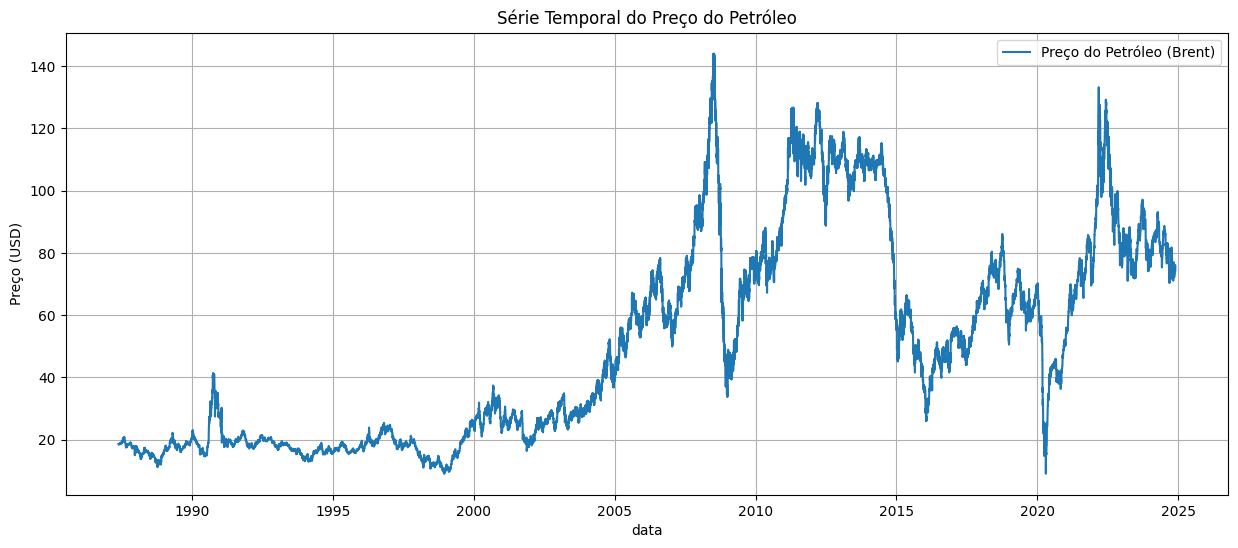

In [598]:
# Plotando o grafico de todos os anos
plt.figure(figsize=(15, 6))
plt.plot(df_ipea['preco'], label='Preço do Petróleo (Brent)')
plt.title('Série Temporal do Preço do Petróleo')
plt.xlabel('data')
plt.ylabel('Preço (USD)')
plt.grid(True)
plt.legend()
plt.show()


## 6 - Visualização dos dados - Séries Temporais


### 6.1 - Decomposição da série período de **20 anos**

- Vamos trabalhar em cima dos ultimos 20 anos onde ouve uma maior oscilação dos valores

In [599]:
# Criando um novo df com base nos ultimos 20 anos
df_ipea_20a = df_ipea[(df_ipea.index.year >= 2004) & (df_ipea.index.year <= 2024)]
df_ipea_20a

preco
data             
2004-01-01  30.30
2004-01-02  29.17
2004-01-03  30.10
2004-01-04  30.30
2004-01-05  32.30
...           ...
2024-11-21  75.09
2024-11-22  76.10
2024-11-23  76.10
2024-11-24  76.10
2024-11-25  74.27

[7635 rows x 1 columns]

In [600]:
media_movel  = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_20a.index, y = df_ipea_20a.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - 20 Anos',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

**Analisando a decomposição da série temporal observamos que :**

> - **Tendência:**  Houve a maior alta no ano de 2008, e a maior queda no ano de 2020 - Será analisado nos topicos abaixo.

> - **Sazonalidade:**   A presença de um padrão repetitivo e regular ao longo dos anos. Isso sugere que fatores específicos a cada mês do ano podem influenciar significativamente o desempenho do índice.

> - **Ruído:** Podemos observar houve alguns pontos que causaram esse ruido .

In [601]:
# Encontrando o Maior e Menor pico
maior_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmax()]
menor_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmin()]

print("Maior valor:")
print(maior_valor)

print("\nMenor valor:")
print(menor_valor)

Maior valor:
preco    143.95
Name: 2008-07-03 00:00:00, dtype: float64

Menor valor:
preco    9.12
Name: 2020-04-21 00:00:00, dtype: float64


### 6.2 - Analisando o grafico da media dos meses do anos de 2008 - Maior Variação

<ipython-input-602-fdc18a2f941e>:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



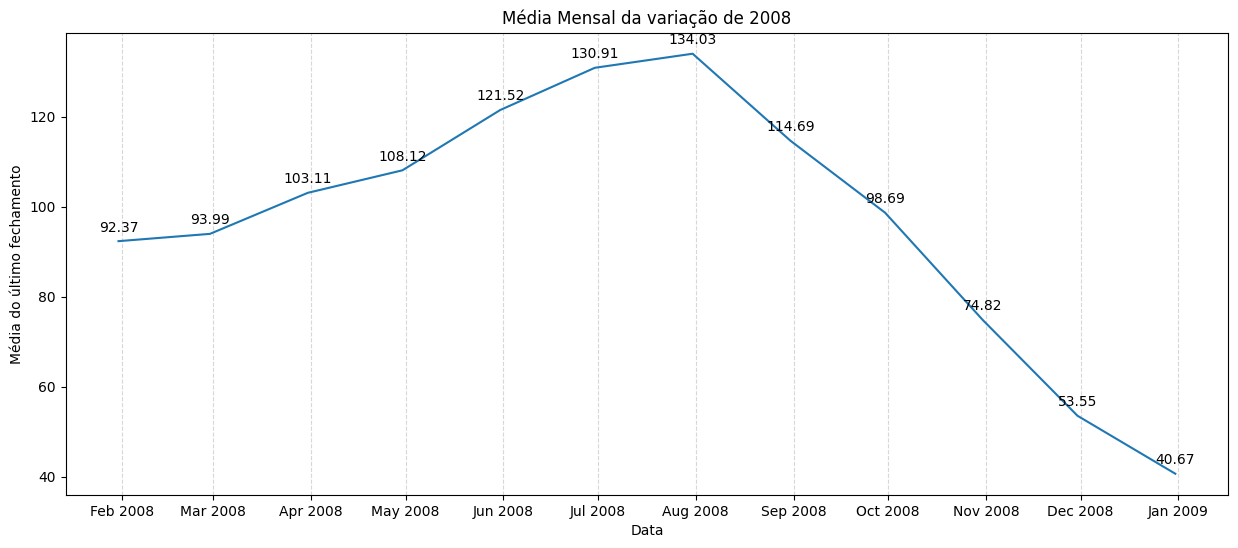

In [602]:
# DataFrame contendo apenas os dados de 2008 para analisar o maior pico
df_ipea_2008 = df_ipea_20a[df_ipea_20a.index.year == 2008]

# Resample para média mensal
df_ipea_2008_resampled_monthly = df_ipea_2008['preco'].resample('M').mean()

# Plotar os dados mensais de 2008
plt.figure(figsize=(15, 6))
plt.plot(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly)
plt.title('Média Mensal da variação de 2008')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,7), ha='center', fontsize=10, color='black')

plt.show()


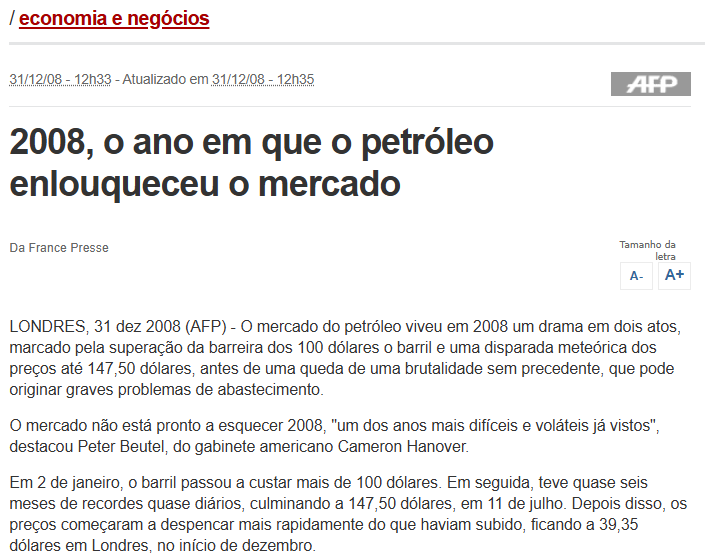




[**2008 - O ano em que o petróleo enlouqueceu o mercado**](https://g1.globo.com/Noticias/Economia_Negocios/0,,MUL940136-9356,00-O+ANO+EM+QUE+O+PETROLEO+ENLOUQUECEU+O+MERCADO.html#:~:text=LONDRES%2C%2031%20dez%202008%20%28AFP%29%20-%20O%20mercado,precedente%2C%20que%20pode%20originar%20graves%20problemas%20de%20abastecimento.
)

### 6.3 - Analisando a média dos meses do anos de 2020 - Menor Media

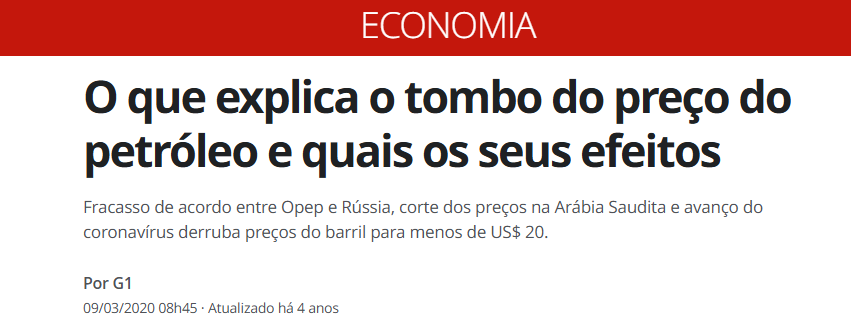


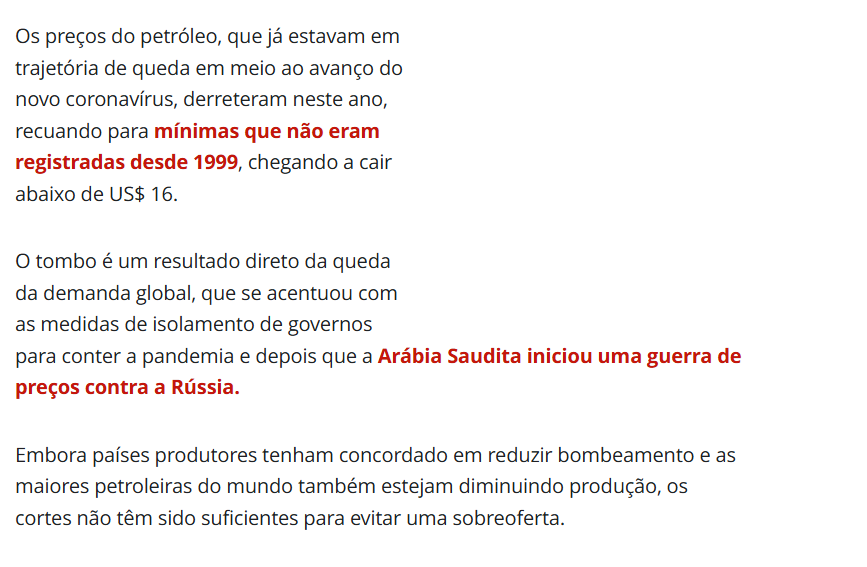

[**2020 - Covid-19 e Queda da demanda global**](https://g1.globo.com/economia/noticia/2020/03/09/o-que-explica-o-tombo-do-preco-do-petroleo-e-quais-os-seus-efeitos.ghtml)

### 6.4 - Analisando a Media dos meses do ano atual

In [603]:
# Selecionando somente o ano atual
df_ipea_2024 = df_ipea[df_ipea.index.year >= 2024]
df_ipea_2024

preco
data             
2024-01-01  77.69
2024-01-02  76.24
2024-01-03  77.18
2024-01-04  75.79
2024-01-05  78.31
...           ...
2024-11-21  75.09
2024-11-22  76.10
2024-11-23  76.10
2024-11-24  76.10
2024-11-25  74.27

[330 rows x 1 columns]

In [604]:
media_movel  = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_2024.index, y = df_ipea_2024.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - 2024',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

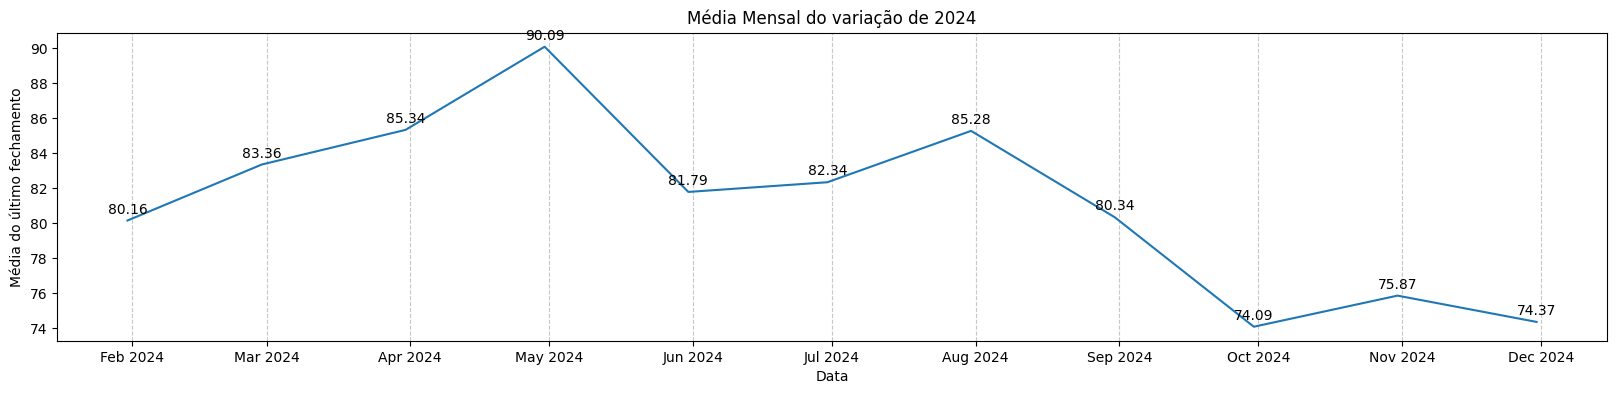

In [605]:
# Resample para média mensal
df_ipea_2024_resampled_mes = df_ipea_2024['preco'].resample('ME').mean()

# Plotar os dados da media mensal de 2024
plt.figure(figsize=(20, 4))
plt.plot(df_ipea_2024_resampled_mes.index, df_ipea_2024_resampled_mes)
plt.title('Média Mensal do variação de 2024')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2024_resampled_mes.index, df_ipea_2024_resampled_mes):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

In [606]:
df_ipea_2024_resampled_mes

data
2024-01-31    80.158710
2024-02-29    83.358621
2024-03-31    85.336129
2024-04-30    90.085000
2024-05-31    81.790000
2024-06-30    82.344000
2024-07-31    85.278065
2024-08-31    80.343226
2024-09-30    74.091000
2024-10-31    75.866774
2024-11-30    74.365600
Freq: ME, Name: preco, dtype: float64

### 6.5 - Observando epoca de eleições presidências

 - Incerteza Política: As eleições geralmente trazem incerteza política, o que pode afetar os mercados financeiros, incluindo o mercado de petróleo. Investidores podem ser mais cautelosos e retraindos, levando a flutuações nos preços.

- Desde a proclamação da República em 1889, o Brasil teve várias eleições presidenciais. As eleições diretas ocorreram nos seguintes anos: 1891, 1894, 1898, 1902, 1906, 1910, 1914, 1918, 1922, 1926, 1930, 1945, 1950, 1955, 1960, 1989, 1994, 1998, 2002, 2006, 2010, 2014, 2018 e 2022.

- As eleições presidenciais no Brasil geralmente ocorrem no mês de outubro. Portanto, os meses que antecedem a votação são julho, agosto e setembro. Durante esses meses, é comum haver um aumento na atividade política, com campanhas eleitorais intensificadas e debates entre os candidatos.

In [607]:
df_dados_transformados =  df_ipea.reset_index()

In [608]:
# Criando novas colunas ano, mes, dia

df_dados_transformados['ano'] = df_dados_transformados['data'].dt.year
df_dados_transformados['mes'] = df_dados_transformados['data'].dt.month
df_dados_transformados['dia'] = df_dados_transformados['data'].dt.day

In [609]:
anos_eleicoes = [1989, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]
meses_eleicoes = [7, 8, 9,10]

In [610]:
#Setando o período eleitoral aos meses

def periodo_eleitoral(row):
    if row['ano'] in anos_eleicoes and row['mes'] in meses_eleicoes:
        return 1
    else:
        return 0

df_dados_transformados['periodo_eleitoral'] = df_dados_transformados.apply(periodo_eleitoral, axis=1)

In [611]:
#Setando o período ano eleitoral
def ano_eleitoral(row):
    if row['ano'] in anos_eleicoes:
        return 1
    else:
        return 0

df_dados_transformados['ano_eleitoral'] = df_dados_transformados.apply(ano_eleitoral, axis=1)

In [612]:
# Atualizar o preço médio dos dados do mês e ano específico
def atualizar_preco_medio_3_anos(df, ano, mes, novo_preco):
    """
    Atualiza o preço médio para um mês e ano específicos no DataFrame.

    Args:
        df: DataFrame com as colunas 'ano', 'mes' e 'preco_medio'.
        ano: O ano para o qual atualizar o preço médio.
        mes: O mês para o qual atualizar o preço médio.
        novo_preco: O novo preço médio.
    """

    # Encontre as linhas correspondentes ao ano e mês especificados
    linhas_a_atualizar = (df['ano'] == ano) & (df['mes'] == mes)

    # Verifique se há linhas correspondentes
    if linhas_a_atualizar.any():
        # Atualize a coluna 'preco_medio' nas linhas encontradas
        df.loc[linhas_a_atualizar, 'media_3_anos'] = novo_preco
    else:
        print(f"Nenhuma linha encontrada para o ano {ano} e mês {mes}.")

In [613]:
# Adicionando o preço médio por mês

df_preco_medio = df_dados_transformados.groupby(['ano', 'mes'])['preco'].mean().reset_index()
df_preco_medio = df_preco_medio.rename(columns={'preco': 'preco_medio'})
df_dados_transformados = pd.merge(df_dados_transformados, df_preco_medio, on=['ano', 'mes'])

In [614]:
# Utilizando somente os meses eleitorais de todos os anos
df_meses_eleicao = df_dados_transformados[df_dados_transformados['mes'].isin(meses_eleicoes)]
df_meses_eleicao = df_meses_eleicao[["data", "preco"]]
df_meses_eleicao.set_index('data', inplace=True)
df_meses_eleicao = df_meses_eleicao.resample('D').asfreq().fillna(0)

- Decompondo a serie

In [615]:
media_movel = df_meses_eleicao_decom = seasonal_decompose(df_meses_eleicao['preco'], model='additive').trend.to_frame()
sazonalidade = df_meses_eleicao_decom = seasonal_decompose(df_meses_eleicao['preco'], model='additive').seasonal.to_frame()
residuo      = df_meses_eleicao_decom = seasonal_decompose(df_meses_eleicao['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_meses_eleicao.index, y = df_meses_eleicao.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - Período eleitoral',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

**Ruído no Gráfico**

- O ruído no gráfico (representado pela linha amarela) refere-se às variações aleatórias e imprevisíveis nos dados que não podem ser explicadas pelos componentes de tendência ou sazonalidade. Este componente captura as flutuações que ocorrem devido a fatores aleatórios ou eventos não sistemáticos.

- No gráfico, o ruído parece ter uma amplitude relativamente constante ao longo do tempo, com algumas variações mais pronunciadas em certos períodos. A análise do ruído é importante para entender a variabilidade inerente aos dados e para melhorar a precisão dos modelos de previsão, isolando os componentes sistemáticos (tendência e sazonalidade) das flutuações aleatórias.

- Abaixo trataremos os dados podendo observar o rúido nos meses de período eleitora e vamos comparar

In [616]:
#Efetuar a media dos tres anos que antecedem cada ano_eleitoral
df_dados_transformados['media_3_anos'] = 0

for ano in anos_eleicoes:
    election_year_indices = df_dados_transformados[df_dados_transformados['ano'] == ano].index

    start_year = ano - 3
    end_year = ano -1

    for mes in range(1,13):

        three_year_data = df_dados_transformados[(df_dados_transformados['ano'] >= start_year) & (df_dados_transformados['ano'] <= end_year)]

        if not three_year_data.empty:
            three_year_data = three_year_data[(three_year_data['mes'] == mes) & three_year_data['dia'] == 1]
            average_price = three_year_data['preco_medio'].mean()
            atualizar_preco_medio_3_anos(df_dados_transformados, ano, mes, average_price)

        else:
            print(f"No data found for the 3-year period preceding {ano}")

<ipython-input-612-af7bbd4546e3>:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.82774193548387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [617]:
#preenchendo a media de 3 anos igual a zero com o preço medio do ano corrente
df_dados_transformados.loc[df_dados_transformados['media_3_anos'] == 0, 'media_3_anos'] = df_dados_transformados['preco_medio']

In [618]:
#Retirando meses diferente do mes eleitoral
#df_filtrado = df_dados_transformados[df_dados_transformados['mes'].isin(meses_eleicoes)]
df_filtrado = df_dados_transformados[df_dados_transformados['dia'] == 1]

In [619]:
df_filtrado

data  preco   ano  mes  dia  periodo_eleitoral  ano_eleitoral  \
12    1987-06-01  18.65  1987    6    1                  0              0   
42    1987-07-01  18.98  1987    7    1                  0              0   
73    1987-08-01  20.03  1987    8    1                  0              0   
104   1987-09-01  18.43  1987    9    1                  0              0   
134   1987-10-01  18.50  1987   10    1                  0              0   
...          ...    ...   ...  ...  ...                ...            ...   
13557 2024-07-01  86.57  2024    7    1                  0              0   
13588 2024-08-01  81.37  2024    8    1                  0              0   
13619 2024-09-01  80.20  2024    9    1                  0              0   
13649 2024-10-01  75.30  2024   10    1                  0              0   
13680 2024-11-01  73.63  2024   11    1                  0              0   

       preco_medio  media_3_anos  
12       18.865667     18.865667  
42       19.846452     19.846452  
73       19.000968     19.000968  
104      18.310333     18.310333  
134      18.771935     18.771935  
...            ...           ...  
13557    85.278065     85.278065  
13588    80.343226     80.343226  
13619    74.091000     74.091000  
13649    75.866774     75.866774  
13680    74.365600     74.365600  

[450 rows x 9 columns]

In [620]:
df_filtrado = df_filtrado[["data", "preco_medio", "media_3_anos"]]

In [621]:
df_filtrado

data  preco_medio  media_3_anos
12    1987-06-01    18.865667     18.865667
42    1987-07-01    19.846452     19.846452
73    1987-08-01    19.000968     19.000968
104   1987-09-01    18.310333     18.310333
134   1987-10-01    18.771935     18.771935
...          ...          ...           ...
13557 2024-07-01    85.278065     85.278065
13588 2024-08-01    80.343226     80.343226
13619 2024-09-01    74.091000     74.091000
13649 2024-10-01    75.866774     75.866774
13680 2024-11-01    74.365600     74.365600

[450 rows x 3 columns]

In [622]:
df_filtrado.set_index('data', inplace=True)

In [623]:
# Gráfico da serie temporal com os campos preco_medio e media_3_anos

plt.figure(figsize=(12, 6))
plt.plot(df_filtrado.index, df_filtrado['preco_medio'], label='Preço Médio')
plt.plot(df_filtrado.index, df_filtrado['media_3_anos'], label='Média 3 Anos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Série Temporal - Preço Médio vs. Média 3 Anos')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

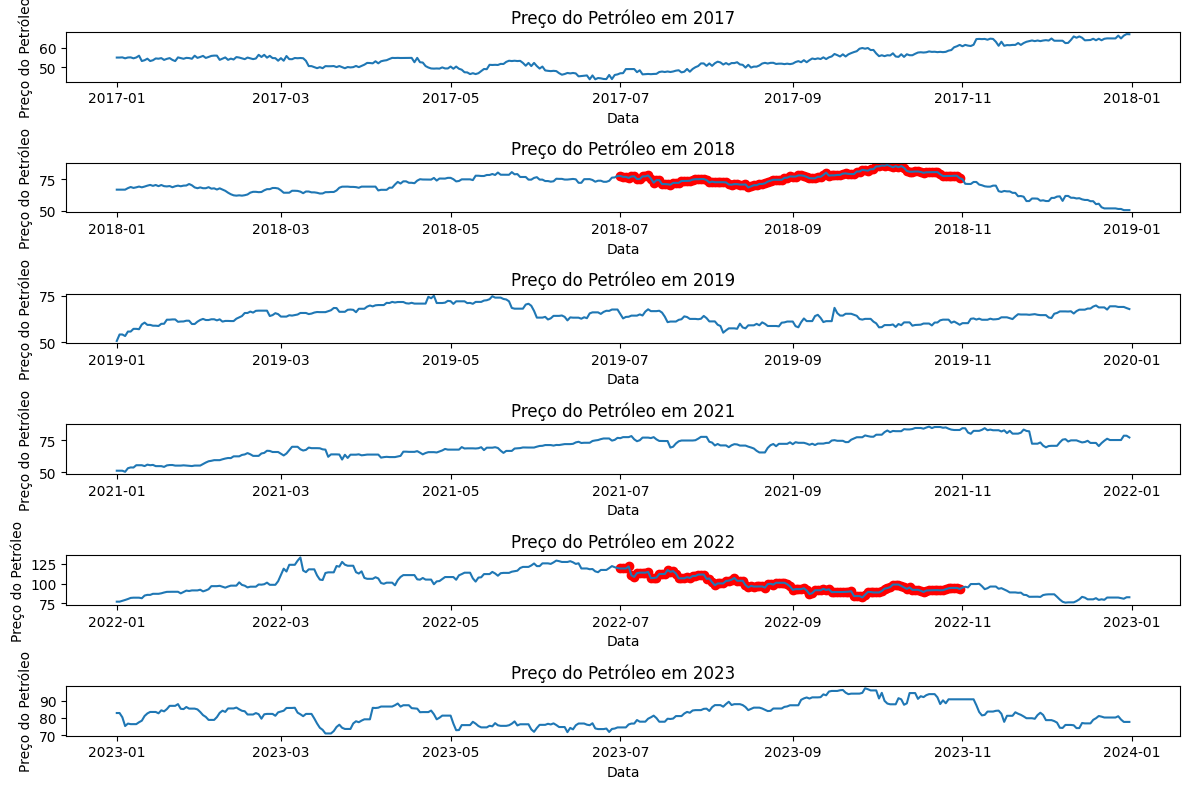

In [624]:
# Filtra os dados para os anos desejados
anos = [2017,2018,2019,2021,2022,2023]  #anos_eleicoes[-2:]

fig, axs = plt.subplots(len(anos), 1, figsize=(12, 8)) # Define o layout dos gráficos

for i, ano in enumerate(anos):
    df_ano = df_dados_transformados[df_dados_transformados['ano'] == ano]

    # Cria o gráfico
    axs[i].plot(df_ano['data'], df_ano['preco'], label=f'Preço do Petróleo {ano}')

    # Adiciona marcadores para os meses de período eleitoral
    eleitoral_months = df_ano[df_ano['periodo_eleitoral'] == 1]
    axs[i].scatter(eleitoral_months['data'], eleitoral_months['preco'], color='red', label='Período Eleitoral')

    # Configurações do gráfico
    axs[i].set_xlabel('Data')
    axs[i].set_ylabel('Preço do Petróleo')
    axs[i].set_title(f'Preço do Petróleo em {ano}')
    #axs[i].tick_params(axis='x', rotation=45)
    #axs[i].legend(title='Meses de Período Eleitoral: Julho, Agosto, Setembro e Outubro')

plt.tight_layout()
plt.show()


### 6.6 - Guerra entre Russia e Ucrania

In [625]:
df_6m = df_ipea_20a.copy()

In [626]:
# Filtrar dados para os primeiros 6 meses
inicio_6m = pd.to_datetime('2022-01-01')
fim_6m = pd.to_datetime('2022-06-30')
dados_6_meses = df_6m.loc[inicio_6m:fim_6m]

preco_medio_6_meses = dados_6_meses['preco'].mean()
preco_min_6_meses = dados_6_meses['preco'].min()
preco_max_6_meses = dados_6_meses['preco'].max()

# Calcular as datas correspondentes aos preços mínimo e máximo
data_min_preco = dados_6_meses[dados_6_meses['preco'] == preco_min_6_meses].index[0]
data_max_preco = dados_6_meses[dados_6_meses['preco'] == preco_max_6_meses].index[0]

# Criar a tabela de estatísticas
estatisticas_precos = pd.DataFrame({
    'Data': [None, data_min_preco.strftime('%Y-%m-%d'), data_max_preco.strftime('%Y-%m-%d'), None],
    'Estatística': ['Média', 'Mínimo', 'Máximo', 'Variação'],
    'Valor (USD)': [
        round(preco_medio_6_meses, 3),
        round(preco_min_6_meses, 3),
        round(preco_max_6_meses, 3),
        round(preco_max_6_meses - preco_min_6_meses, 3)
    ]
})

# Exibir a tabela corrigida
estatisticas_precos


Data Estatística  Valor (USD)
0        None       Média      107.229
1  2022-01-01      Mínimo       77.240
2  2022-03-08      Máximo      133.180
3        None    Variação       55.940

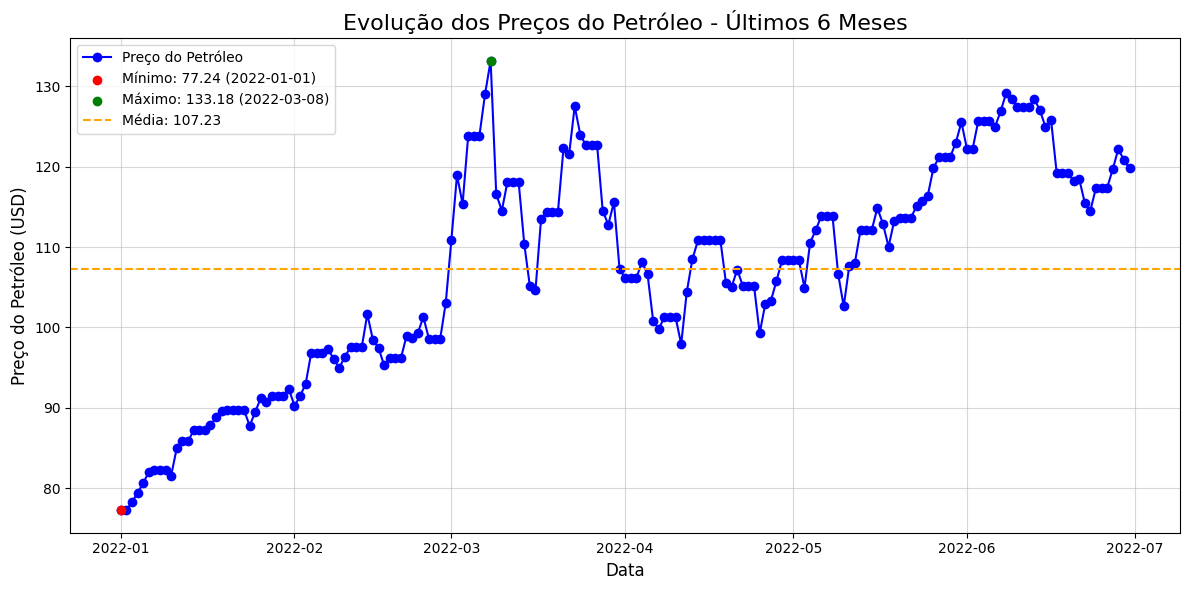

In [627]:
# Configurar o gráfico
plt.figure(figsize=(12, 6))

# Gráfico de linha para os preços ao longo do tempo
plt.plot(dados_6_meses.index, dados_6_meses['preco'], label='Preço do Petróleo', color='blue', linestyle='-', marker='o')

# Adicionar marcadores para o preço mínimo e máximo
plt.scatter(data_min_preco, preco_min_6_meses, color='red', label=f'Mínimo: {preco_min_6_meses:.2f} ({data_min_preco.strftime("%Y-%m-%d")})', zorder=5)
plt.scatter(data_max_preco, preco_max_6_meses, color='green', label=f'Máximo: {preco_max_6_meses:.2f} ({data_max_preco.strftime("%Y-%m-%d")})', zorder=5)

# Linha horizontal para o preço médio
plt.axhline(preco_medio_6_meses, color='orange', linestyle='--', label=f'Média: {preco_medio_6_meses:.2f}')

# Ajustar título e legendas
plt.title('Evolução dos Preços do Petróleo - Últimos 6 Meses', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço do Petróleo (USD)', fontsize=12)
plt.legend()
plt.grid(alpha=0.5)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


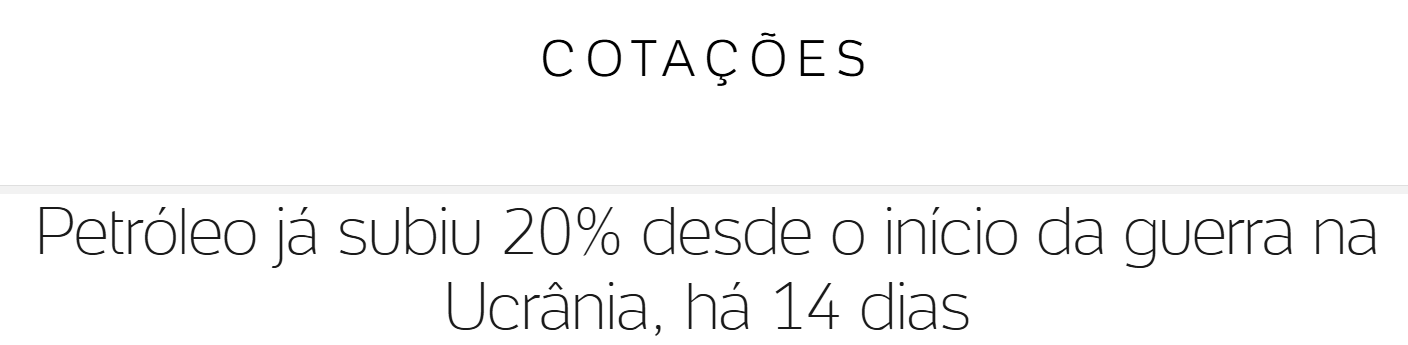

image.png

[2022 - Inicio da guerra Rússia e Ucrania](https://economia.uol.com.br/cotacoes/noticias/redacao/2022/03/09/preco-do-petroleo-guerra-na-ucrania.htm)

## 7 - Analisando a Média Movel 10 e 20 dias

In [628]:
df_ipea_10_20 = df_ipea_2024.copy()

# Ordenar o índice por data de forma decrescente
df_ipea_10_20 = df_ipea_10_20.sort_index(ascending=False)

# Calcular médias móveis de 10 e 20 dias (deslocadas)
df_ipea_10_20['media_10_dias'] = df_ipea_10_20['preco'].rolling(10, min_periods=1).mean().shift()
df_ipea_10_20['media_20_dias'] = df_ipea_10_20['preco'].rolling(20, min_periods=1).mean().shift()

# Inspecionar as primeiras linhas do DataFrame
df_ipea_10_20.head(30)

preco  media_10_dias  media_20_dias
data                                           
2024-11-25  74.27            NaN            NaN
2024-11-24  76.10      74.270000      74.270000
2024-11-23  76.10      75.185000      75.185000
2024-11-22  76.10      75.490000      75.490000
2024-11-21  75.09      75.642500      75.642500
2024-11-20  74.33      75.532000      75.532000
2024-11-19  74.32      75.331667      75.331667
2024-11-18  74.35      75.187143      75.187143
2024-11-17  73.45      75.082500      75.082500
2024-11-16  73.45      74.901111      74.901111
2024-11-15  73.45      74.756000      74.756000
2024-11-14  73.39      74.674000      74.637273
2024-11-13  72.86      74.403000      74.533333
2024-11-12  72.56      74.079000      74.404615
2024-11-11  72.19      73.725000      74.272857
2024-11-10  74.04      73.435000      74.134000
2024-11-09  74.04      73.406000      74.128125
2024-11-08  74.04      73.378000      74.122941
2024-11-07  75.73      73.347000      74.118333
2024-11-06  76.52      73.575000      74.203158
2024-11-05  76.98      73.882000      74.319000
2024-11-04  74.89      74.235000      74.454500
2024-11-03  73.63      74.385000      74.394000
2024-11-02  73.63      74.462000      74.270500
2024-11-01  73.63      74.569000      74.147000
2024-10-31  73.25      74.713000      74.074000
2024-10-30  73.21      74.634000      74.020000
2024-10-29  71.09      74.551000      73.964500
2024-10-28  71.87      74.256000      73.801500
2024-10-27  75.62      73.870000      73.722500

- Plotando o gráfico

In [629]:
fig = px.line(
    df_ipea_10_20['preco'],
    template = template,
    color_discrete_sequence = ['#B22222']
)

fig.add_scatter(
    x = df_ipea_10_20.index,
    y =  df_ipea_10_20['media_10_dias'],
    name = 'Media 10 dias',
    marker = dict(color = '#00008B')
)

fig.add_scatter(
    x = df_ipea_10_20.index,
    y =  df_ipea_10_20['media_20_dias'],
    name = 'Media 20 dias',
    marker = dict(color = '#Ffa500')
)
fig.update_layout(
    title = 'Média Móvel Semanal X Média Móvel 2024 Preço Petroleo',
    xaxis_title = 'Período',
    yaxis_title = 'Valor Petroleo',
    legend_title = 'Legenda',
    width = 1100,
    height = 600,
    margin = dict(l = 100, r = 20, t = 80, b = 80)
)

fig.show()

### 7.1 - Teste ADF para estacionaria ou não estacionaria


In [630]:
df_ipea_24 = df_ipea_2024.copy()

In [631]:
# Criando a coluna 'abertura' baseada no preço do dia anterior
df_ipea_24['abertura'] = df_ipea_24['preco'].shift(1)
df_ipea_24['abertura'] = df_ipea_24['abertura'].fillna(df_ipea_24['preco'])  # Preencher o primeiro valor com o preço original


# Criar a coluna 'fechamento' (igual à coluna 'preco')
df_ipea_24['fechamento'] = df_ipea_24['preco']

# Ordenar o índice por data de forma decrescente
df_ipea_24 = df_ipea_24.sort_index(ascending=False)

# Exibir as primeiras linhas com as novas colunas
df_ipea_24.head(10)


preco  abertura  fechamento
data                                   
2024-11-25  74.27     76.10       74.27
2024-11-24  76.10     76.10       76.10
2024-11-23  76.10     76.10       76.10
2024-11-22  76.10     75.09       76.10
2024-11-21  75.09     74.33       75.09
2024-11-20  74.33     74.32       74.33
2024-11-19  74.32     74.35       74.32
2024-11-18  74.35     73.45       74.35
2024-11-17  73.45     73.45       73.45
2024-11-16  73.45     73.45       73.45

In [632]:
x = df_ipea_24['preco'].values

In [633]:
resultado = adfuller(x)

print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-value: {resultado[1]}")
print("Valores críticos: ")
print(f"É estacionária: {resultado[1] < 0.05}")

for key, value in resultado[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.169344637178591
P-value: 0.2175590730140231
Valores críticos: 
É estacionária: False
	1%: -3.4503836022181056
	5%: -2.8703653471616826
	10%: -2.571471939191249


- Analisando o resultado fica evidente que a serie ainda não esta estacionaria.

- Pois o valor do teste estatístico esta maior que os valores criticos, e nosso p-value não esta proximo do zero

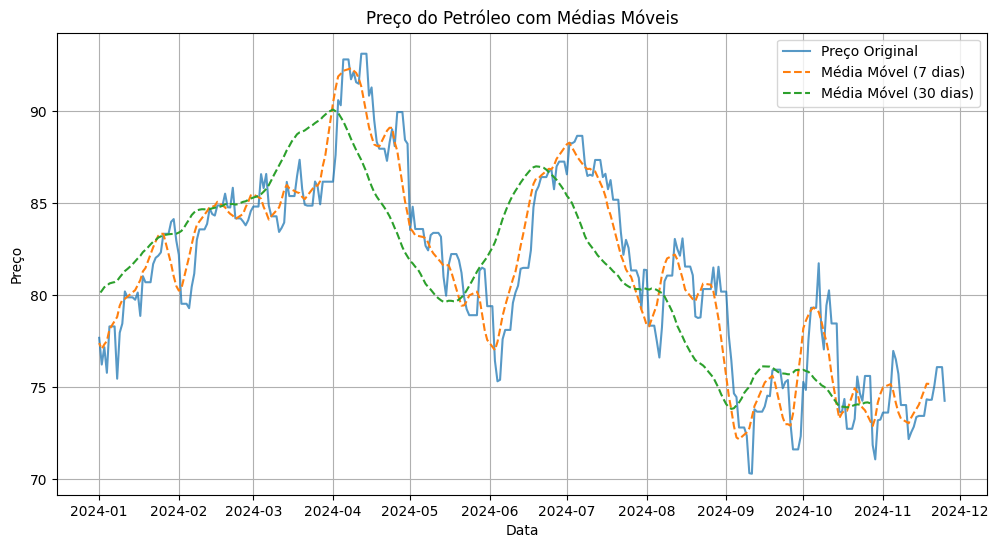

In [634]:
df_ipea_24_ma = df_ipea_24.copy()
# Calcular médias móveis de diferentes janelas (7 e 30 dias)
df_ipea_24_ma['media_movel_7'] = df_ipea_24_ma['preco'].rolling(window=7).mean()
df_ipea_24_ma['media_movel_30'] = df_ipea_24_ma['preco'].rolling(window=30).mean()

# Plotar a série original junto com as médias móveis
plt.figure(figsize=(12, 6))
plt.plot(df_ipea_24_ma.index, df_ipea_24_ma['preco'], label='Preço Original', alpha=0.75)
plt.plot(df_ipea_24_ma.index, df_ipea_24_ma['media_movel_7'], label='Média Móvel (7 dias)', linestyle='--')
plt.plot(df_ipea_24_ma.index, df_ipea_24_ma['media_movel_30'], label='Média Móvel (30 dias)', linestyle='--')
plt.title('Preço do Petróleo com Médias Móveis')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid()
plt.show()

In [635]:
df_ipea_24_ma

preco  abertura  fechamento  media_movel_7  media_movel_30
data                                                                  
2024-11-25  74.27     76.10       74.27            NaN             NaN
2024-11-24  76.10     76.10       76.10            NaN             NaN
2024-11-23  76.10     76.10       76.10            NaN             NaN
2024-11-22  76.10     75.09       76.10            NaN             NaN
2024-11-21  75.09     74.33       75.09            NaN             NaN
...           ...       ...         ...            ...             ...
2024-01-05  78.31     75.79       78.31      78.148571       80.643333
2024-01-04  75.79     77.18       75.79      77.517143       80.518333
2024-01-03  77.18     76.24       77.18      77.334286       80.439667
2024-01-02  76.24     77.69       76.24      77.087143       80.241000
2024-01-01  77.69     77.69       77.69      77.404286       80.064667

[330 rows x 5 columns]

### 7.2 - Transformando a série em estacionaria - Aplicando adfuller

In [636]:
# Aplicar a primeira diferença na coluna de preços
df_ipea_24['preco_diff'] = df_ipea_24['preco'].diff()

# Remover os valores nulos gerados pela diferença
df_ipea_24_diff = df_ipea_24.dropna()

# Realizar o teste ADF novamente na série transformada
adf_test_diff_result = adfuller(df_ipea_24_diff['preco_diff'])

# Organizar os resultados
print("Teste ADF")
print(f"Teste Estatístico: {adf_test_diff_result[0]}")
print(f"P-value: {adf_test_diff_result[1]}")
print(f"Lags usados: {adf_test_diff_result[2]}")
print(f"Número de observações: {adf_test_diff_result[3]}")
print("Valores críticos: ")
print(f"É estacionária: {adf_test_diff_result[1] < 0.05}")


for key, value in adf_test_diff_result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -18.184813122170233
P-value: 2.4277619553524865e-30
Lags usados: 0
Número de observações: 328
Valores críticos: 
É estacionária: True
	1%: -3.4504451681828194
	5%: -2.870392380216117
	10%: -2.571486353732897


In [637]:
df_ipea_24_diff

preco  abertura  fechamento  preco_diff
data                                               
2024-11-24  76.10     76.10       76.10        1.83
2024-11-23  76.10     76.10       76.10        0.00
2024-11-22  76.10     75.09       76.10        0.00
2024-11-21  75.09     74.33       75.09       -1.01
2024-11-20  74.33     74.32       74.33       -0.76
...           ...       ...         ...         ...
2024-01-05  78.31     75.79       78.31        0.00
2024-01-04  75.79     77.18       75.79       -2.52
2024-01-03  77.18     76.24       77.18        1.39
2024-01-02  76.24     77.69       76.24       -0.94
2024-01-01  77.69     77.69       77.69        1.45

[329 rows x 4 columns]

### 7.4 - Plot_acf e Plot_pacf

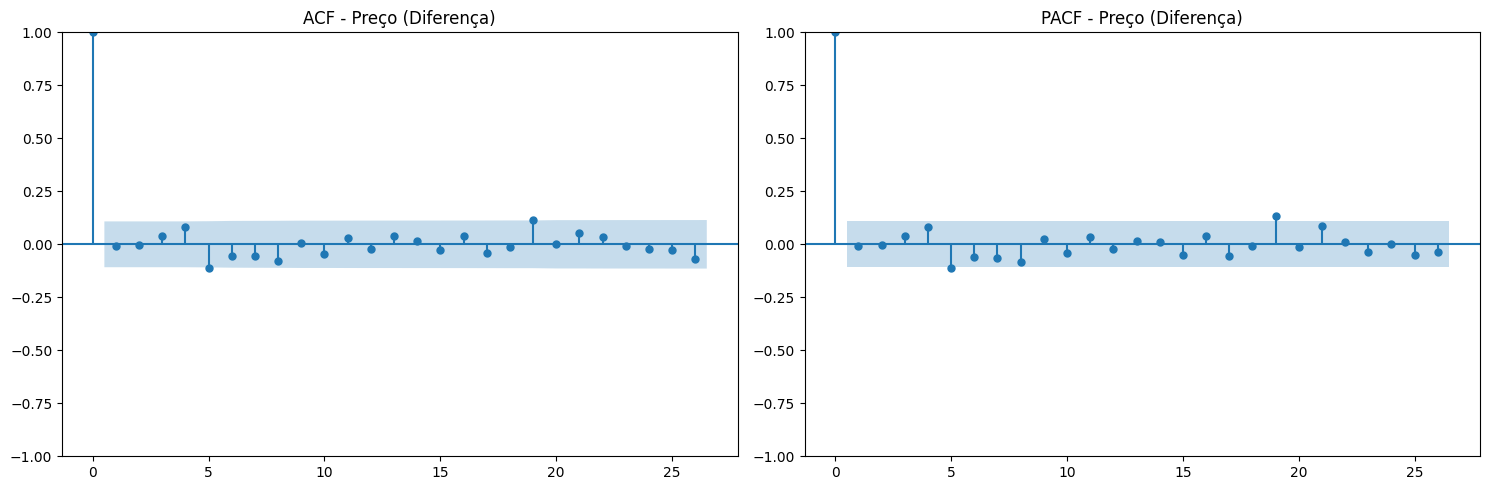

In [638]:
# Plotar ACF e PACF da série diferenciada
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_ipea_24_diff['preco_diff'], ax=axes[0], title="ACF - Preço (Diferença)")
plot_pacf(df_ipea_24_diff['preco_diff'], ax=axes[1], title="PACF - Preço (Diferença)", method='ywm')

plt.tight_layout()
plt.show()

## 8 - Machine Learn

### 8.1 - Criando métricas para validação dos modelos

- Erro Absoluto Médio (MAE)
- Erro Percentual Médio Absoluto (MAPE)
- Erro Quadrático Médio (MSE)



In [639]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

### 8.2 - Modelo - SARIMAX

In [640]:
df_ml = df_ipea_24_diff.copy()
df_ml.reset_index(inplace=True)

In [641]:
test_data

index       data  preco  abertura  fechamento  preco_diff
263    263 2024-03-06  86.59     85.82       86.59        1.71
264    264 2024-03-05  85.82     86.58       85.82       -0.77
265    265 2024-03-04  86.58     84.82       86.58        0.76
266    266 2024-03-03  84.82     84.82       84.82       -1.76
267    267 2024-03-02  84.82     84.82       84.82        0.00
..     ...        ...    ...       ...         ...         ...
324    324 2024-01-05  78.31     75.79       78.31        0.00
325    325 2024-01-04  75.79     77.18       75.79       -2.52
326    326 2024-01-03  77.18     76.24       77.18        1.39
327    327 2024-01-02  76.24     77.69       76.24       -0.94
328    328 2024-01-01  77.69     77.69       77.69        1.45

[66 rows x 6 columns]

In [642]:
df_ml_sarimax = df_ipea_24_diff.copy()
df_ml_sarimax.reset_index(inplace=True)

In [643]:
df_ml_sarimax

data  preco  abertura  fechamento  preco_diff
0   2024-11-24  76.10     76.10       76.10        1.83
1   2024-11-23  76.10     76.10       76.10        0.00
2   2024-11-22  76.10     75.09       76.10        0.00
3   2024-11-21  75.09     74.33       75.09       -1.01
4   2024-11-20  74.33     74.32       74.33       -0.76
..         ...    ...       ...         ...         ...
324 2024-01-05  78.31     75.79       78.31        0.00
325 2024-01-04  75.79     77.18       75.79       -2.52
326 2024-01-03  77.18     76.24       77.18        1.39
327 2024-01-02  76.24     77.69       76.24       -0.94
328 2024-01-01  77.69     77.69       77.69        1.45

[329 rows x 5 columns]

In [644]:
# Configurar o modelo SARIMAX
sarimax_model = SARIMAX(
    df_ml_sarimax['preco_diff'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),  # Sem diferenciação sazonal (D=0) porque já está estacionária
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = sarimax_model.fit(disp=False)

# Fazer previsões para 7 dias
forecast_dif = sarimax_fit.forecast(steps=7)

# Reverter a diferenciação para os valores originais
ultimo_valor = df_ml_sarimax['preco'].iloc[-1]
forecast_original = [ultimo_valor + np.sum(forecast_dif[:i+1]) for i in range(len(forecast_dif))]

# Calcular métricas
residuals = sarimax_fit.resid
metrics_sarimax = calculate_metrics(df_ml_sarimax['preco_diff'], residuals)


print("Previsões SARIMAX:")
print(forecast_original)
print("Métricas SARIMAX:")
print_metrics(metrics_sarimax)

Previsões SARIMAX:
[77.52548532681756, 77.52896708751233, 77.52824337410928, 77.66145109404164, 77.58211602906434, 77.62885036839401, 77.54270199095707]
Métricas SARIMAX:
MAE: 0.04360762502736951
MSE: 0.004527946195475387
MAPE: inf


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### 8.3 Modelo PROPHET

In [645]:
df_ml_prophet = df_ipea_24_diff.copy()
df_ml_prophet.reset_index(inplace=True)

In [646]:
df_ml_prophet

data  preco  abertura  fechamento  preco_diff
0   2024-11-24  76.10     76.10       76.10        1.83
1   2024-11-23  76.10     76.10       76.10        0.00
2   2024-11-22  76.10     75.09       76.10        0.00
3   2024-11-21  75.09     74.33       75.09       -1.01
4   2024-11-20  74.33     74.32       74.33       -0.76
..         ...    ...       ...         ...         ...
324 2024-01-05  78.31     75.79       78.31        0.00
325 2024-01-04  75.79     77.18       75.79       -2.52
326 2024-01-03  77.18     76.24       77.18        1.39
327 2024-01-02  76.24     77.69       76.24       -0.94
328 2024-01-01  77.69     77.69       77.69        1.45

[329 rows x 5 columns]

In [647]:
from prophet import Prophet

# Preparar os dados
df_prophet_diff = df_ml_prophet[['data', 'preco_diff']].rename(columns={'data': 'ds', 'preco_diff': 'y'})

# Treinar o modelo Prophet
prophet_model = Prophet()
prophet_model.fit(df_prophet_diff)

# Fazer previsões futuras
future_dates = prophet_model.make_future_dataframe(periods=7)
forecast = prophet_model.predict(future_dates)

# Reverter a diferenciação para os valores originais
ultimo_valor = df_ml_prophet['preco'].iloc[-1]
forecast['yhat_original'] = ultimo_valor + forecast['yhat'].cumsum()

# Calcular métricas
y_test = df_ml_prophet['preco_diff'][-7:].values
y_pred = forecast['yhat'][-7:].values
metrics_prophet = calculate_metrics(y_test, y_pred)

print("Previsões Prophet:")
print(forecast[['ds', 'yhat_original']].tail(7))
print("Métricas Prophet:")
print_metrics(metrics_prophet)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgvv23_ia/2q6re2_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgvv23_ia/pk4w9pyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76448', 'data', 'file=/tmp/tmpgvv23_ia/2q6re2_b.json', 'init=/tmp/tmpgvv23_ia/pk4w9pyk.json', 'output', 'file=/tmp/tmpgvv23_ia/prophet_modelr7vw03g5/prophet_model-20241204015607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:56:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Previsões Prophet:
            ds  yhat_original
329 2024-11-25      81.093937
330 2024-11-26      81.299263
331 2024-11-27      80.817640
332 2024-11-28      80.940364
333 2024-11-29      81.022423
334 2024-11-30      81.066160
335 2024-12-01      81.397802
Métricas Prophet:
MAE: 1.3577696752350623
MSE: 2.690105630168025
MAPE: inf


<ipython-input-639-e013d831e7e9>:4: RuntimeWarning:

divide by zero encountered in divide



### 8.4 - Comparando os modelos


In [648]:
df_result = pd.DataFrame(
    [metrics_prophet, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["Prophet", "Sarimax"],
)
df_result

MAE       MSE  MAPE
Prophet  1.357770  2.690106   inf
Sarimax  0.043608  0.004528   inf

## 9 - Streamlit


In [649]:
df_st = df_ipea_20a.copy()
df_st = df_st.sort_index(ascending=False)
df_st = df_st.reset_index()  # Reseta o índice
df_st['mes'] = df_st['data'].dt.month
df_st['ano'] = df_st['data'].dt.year
df_st = df_st.sort_values(by='data', ascending=True)
df_st['variacao_%'] = round(df_st['preco'].pct_change() * 100, 2)
df_st.head()

data  preco  mes   ano  variacao_%
7634 2004-01-01  30.30    1  2004         NaN
7633 2004-01-02  29.17    1  2004       -3.73
7632 2004-01-03  30.10    1  2004        3.19
7631 2004-01-04  30.30    1  2004        0.66
7630 2004-01-05  32.30    1  2004        6.60

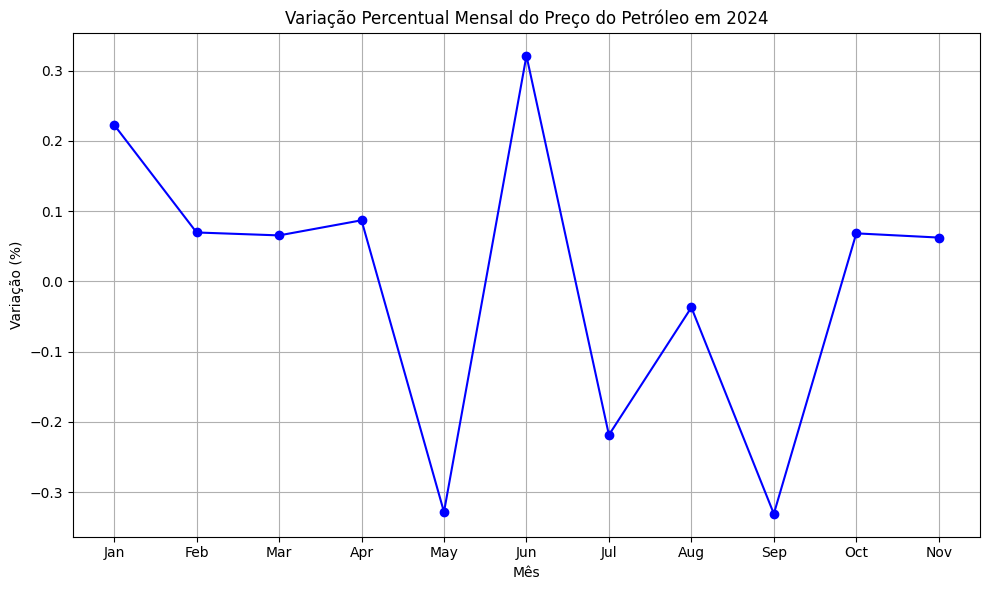

In [650]:
# Filtrar os dados do último ano
ultimo_ano = df_st['ano'].max()  # Obter o último ano
df_ultimo_ano = df_st[df_st['ano'] == ultimo_ano]

# Agrupar por mês e calcular a variação média
df_ultimo_ano_mensal = df_ultimo_ano.groupby(['ano', 'mes']).agg({'variacao_%': 'mean'}).reset_index()

# Plotar o gráfico da variação percentual por mês
plt.figure(figsize=(10,6))
plt.plot(df_ultimo_ano_mensal['mes'], df_ultimo_ano_mensal['variacao_%'], marker='o', linestyle='-', color='b')
plt.title(f'Variação Percentual Mensal do Preço do Petróleo em {ultimo_ano}')
plt.xlabel('Mês')
plt.ylabel('Variação (%)')
plt.grid(True)

meses_unicos = sorted(df_ultimo_ano_mensal['mes'].unique())

meses_labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
][0:len(meses_unicos)]

plt.xticks(meses_unicos, meses_labels)
plt.tight_layout()
plt.show()

### 9.1 - Criando base concatenada ano

In [651]:
df_ipea_dash = df_ipea.copy()
df_ipea_dash.reset_index(inplace=True)
df_ipea_dash

data  preco
0     1987-05-20  18.63
1     1987-05-21  18.45
2     1987-05-22  18.55
3     1987-05-23  18.55
4     1987-05-24  18.55
...          ...    ...
13700 2024-11-21  75.09
13701 2024-11-22  76.10
13702 2024-11-23  76.10
13703 2024-11-24  76.10
13704 2024-11-25  74.27

[13705 rows x 2 columns]

In [652]:
# Converter as colunas para os tipos corretos
df_ipea_dash['data'] = pd.to_datetime(df_ipea_dash['data'], format='%d/%m/%Y', errors='coerce')
# Ensure the 'preco' column is of type string before using .str
df_ipea_dash['preco'] = df_ipea_dash['preco'].astype(str).str.replace(',', '.').astype(float)

# Criar uma coluna para o ano
df_ipea_dash['ano'] = df_ipea_dash['data'].dt.year

# Calcular as métricas por ano
# Use df_ipea_dash instead of data for groupby
df_ipea_dash = df_ipea_dash.groupby('ano')['preco'].agg(['mean', 'min', 'max']).reset_index()
df_ipea_dash.rename(columns={'ano': 'Ano','mean': 'Média', 'min': 'Mínima', 'max': 'Máxima'}, inplace=True)

# Adicionar a comparação com o ano anterior
df_ipea_dash['Variação_Média'] = df_ipea_dash['Média'].pct_change() * 100

df_ipea_dash['Produto'] = 'petroleo'

df_ipea_dash.to_csv('df_ipea_dash.csv', index=False)

df_ipea_dash

Ano       Média  Mínima  Máxima  Variação_Média   Produto
0   1987   18.530929   15.03   20.95             NaN  petroleo
1   1988   14.957158   11.20   17.95      -19.285437  petroleo
2   1989   18.268822   16.05   22.25       22.140993  petroleo
3   1990   23.703973   14.68   41.45       29.750964  petroleo
4   1991   20.022055   17.60   30.28      -15.532915  petroleo
5   1992   19.319699   17.05   21.55       -3.507908  petroleo
6   1993   17.030521   13.13   19.60      -11.848936  petroleo
7   1994   15.820603   13.00   19.03       -7.104409  petroleo
8   1995   17.034521   15.35   19.38        7.673019  petroleo
9   1996   20.635984   16.23   25.40       21.142145  petroleo
10  1997   19.143726   15.86   24.83       -7.231337  petroleo
11  1998   12.780027    9.10   16.28      -33.241693  petroleo
12  1999   17.880411    9.77   26.46       39.909019  petroleo
13  2000   28.535301   21.05   37.43       59.589735  petroleo
14  2001   24.456137   16.51   30.68      -14.295148  petroleo
15  2002   24.982548   18.17   32.02        2.152470  petroleo
16  2003   28.865836   23.23   34.94       15.544002  petroleo
17  2004   38.140519   29.02   52.28       32.130314  petroleo
18  2005   54.331945   38.93   67.26       42.452034  petroleo
19  2006   65.100082   55.82   78.26       19.819163  petroleo
20  2007   72.258986   49.95   95.66       10.996767  petroleo
21  2008   97.217377   33.73  143.95       34.540189  petroleo
22  2009   61.286137   34.16   78.68      -36.959689  petroleo
23  2010   79.461151   67.18   93.63       29.655995  petroleo
24  2011  111.306521   92.50  126.64       40.076653  petroleo
25  2012  111.600738   88.69  128.14        0.264331  petroleo
26  2013  108.640795   96.84  118.90       -2.652261  petroleo
27  2014   99.302219   55.27  115.19       -8.595828  petroleo
28  2015   52.543014   35.26   66.33      -47.087775  petroleo
29  2016   43.506230   26.01   54.95      -17.198831  petroleo
30  2017   54.193918   43.98   66.80       24.565880  petroleo
31  2018   71.048658   50.57   86.07       31.100796  petroleo
32  2019   64.284247   50.57   74.94       -9.520815  petroleo
33  2020   41.837514    9.12   70.25      -34.917937  petroleo
34  2021   70.679096   50.37   85.76       68.937133  petroleo
35  2022  100.957945   76.02  133.18       42.839893  petroleo
36  2023   82.520192   71.03   97.10      -18.262806  petroleo
37  2024   81.285152   70.31   93.12       -1.496652  petroleo

### 10 - Conclusão do Projeto

 **Este projeto abordou a análise e previsão dos preços históricos do petróleo Brent, com o objetivo de fornecer insights relevantes para a tomada de decisão estratégica e desenvolver uma solução preditiva utilizando ferramentas modernas de Machine Learning.**

**O trabalho foi estruturado em quatro pilares principais:**

*   ***Análise Exploratória de Dados:***

 - A análise histórica permitiu identificar fatores influenciadores dos preços, como crises econômicas globais, eventos geopolíticos, tensões entre paises e pandemia mundial.

 - Foram destacados momentos de impacto significativo, como a crise financeira de 2008 e os efeitos da COVID-19.


* ***Desenvolvimento do Modelo Preditivo:***

 - Um modelo de previsão de séries temporais foi implementado para estimar os preços diários do petróleo. As métricas de avaliação indicaram que o modelo é funcional e atende aos requisitos iniciais, apesar das limitações inerentes à volatilidade do mercado.
Métricas como MAE e MAPE demonstraram que o modelo é confiável dentro do escopo proposto.

*   **Dashboard Interativo:**

 - Um dashboard foi desenvolvido para apresentar insights de maneira clara e interativa, conectando os resultados da análise com o storytelling necessário para apoiar decisões estratégicas.



*   **Plano de Deploy:**

  - Foi criado um protótipo funcional utilizando o Streamlit, permitindo que as previsões sejam acessadas em um ambiente simples e amigável, pronto para ser utilizado em produção com aprimoramentos futuros.


*   **Resultados e Contribuições**

 - O projeto atendeu aos objetivos iniciais, oferecendo:

 - Insights estratégicos baseados nos dados históricos de preços do petróleo.

 - Ferramentas preditivas que permitem estimar valores futuros e ajudam no planejamento estratégico.

  - Uma solução interativa que une storytelling e visualização de dados para facilitar a tomada de decisão.

 - Embora o modelo tenha apresentado limitações devido à alta variabilidade dos preços do petróleo, ele representa um bom ponto de partida e pode ser aprimorado com a inclusão de variáveis externas, como dados macroeconômicos e geopolíticos.